# Discrete fourier transforms and phase

(under construction)

This page demonstrates the use of a fourier transform to compute the range to reflectors in ApRES data. 

The idealized sinusoidal signals used in these demonstrations are intended to be simplified version of the signals recorded by ApRES. Specifically, they represent the signal obtained when the received signal is differenced with the transmitted signal. In general this results in a signal with a wide range of different frequencies. However, we will construct our synthetic signal with only two frequencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

## 1. Define some reflectors
Suppose that there are just two reflectors beneath you when you deploy ApRES. In reality there are hundreds, but we will assume there are just two.

Let's use $R$ as the range, and define the range to the two reflectors as

In [2]:
R1 = 50.0  # units [m]
R2 = 120.0  # units [m]

## 2. Compute the two-way travel time to the reflectors
The two-way radio-wave travel time in ice $\tau$ is given by


```{math}
:label: eq:tau1
\tau = 2R\frac{\sqrt\epsilon}{c},
```

where $c$ is the speed of light in a vacuum and $\epsilon$ is the dielactric constant of ice.

Next, let's use constants from {cite}`brennan_phase-sensitive_2014`, to compute $\tau$ for our two reflectors:


In [3]:
ep = 3.1
c = 299792458
tau1 = 2*R1*np.sqrt(ep)/c
tau2 = 2*R2*np.sqrt(ep)/c
print(f'tau1 is {tau1:.3e} s.')
print(f'tau2 is {tau2:.3e} s.')

tau1 is 5.873e-07 s.
tau2 is 1.410e-06 s.


## 3. Compute the beat frequencies we would receive from these reflectors
Equation 1 from Brennan et al. relates the difference in frequency between the transmitted and received signals (the beat frequency; $f_d$) to $\tau$ using some configuration parameters related to how the frequency changes during each chirp:

```{math}
:label: eq:f_d1
f_d = K\tau = \frac{2\pi B \tau}{T}, 
```

where $K$ is the rate of frequency increase in Hz s$^{-1}$, $B$ is the bandwidth (the difference between the lowest and highest frequency covered by each chirp), and $T$ is the chirp duration. 

Again using parameters from Brennan et al., let's compute the beat frequencies we expect to receive from our two reflectors:

In [4]:
B = 200e6           # [Hz]
T = 1               # [s]
K = B/T             # [Hz/s^2]

f1 = K*tau1     # [Hz]
f2 = K*tau2     # [Hz]

print(f'f1 = {f1:.2f} Hz.')
print(f'f2 = {f2:.2f} Hz.')

f1 = 117.46 Hz.
f2 = 281.90 Hz.


## 4. Construct our signal
The signal ApRES recieves is the sum of two sinusoids. One has a frequency of `f1` and the other `f2`. 

Before computing the received signal, we need to define a sampling frequncy, which is controlled by the ApRES system (Brennan used 12 kHz),

In [5]:
sampling_frequency = 12e3    # [Hz]

and define a sampling vector,

In [6]:
samplingInterval       = 1 / sampling_frequency;   # [s]
t = np.arange(0,T,samplingInterval)                # [s]

Now we can define the signal ApRES receives

In [7]:
s = np.exp(1j*2*np.pi*f1*t)  + np.exp(1j*(2*np.pi*f2*t))     

Plot the signal to convince ourselves that this is an oscillatory signal.
 
The code below plots a small section of the real and imaginary parts of `s` on the left and both components against each other in the complex plane (on an Argand diagram) on the right.

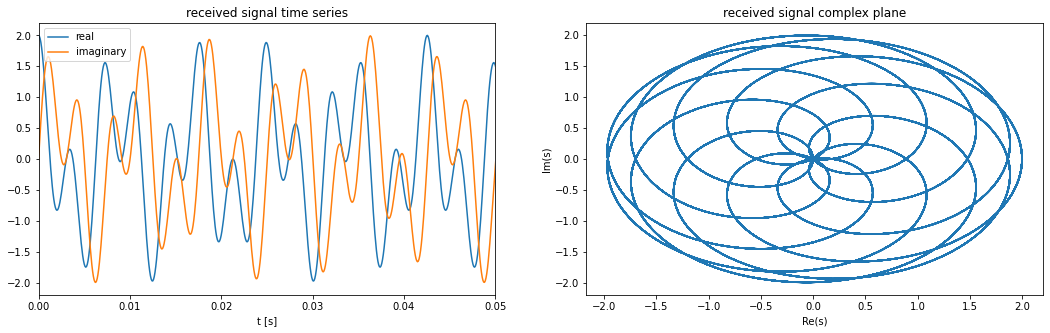

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

# the real and imaginary components of the signal in the plot on the left
ax1.plot(t,s.real,label='real')
ax1.set_title('received signal time series')
ax1.set_xlabel('t [s]')
ax1.set_xlim(0, 0.05)
ax1.plot(t,s.imag,label='imaginary')
ax1.legend()

# The Argand diagram on the right
ax2.plot(s.real,s.imag)
ax2.set_title('received signal complex plane')
ax2.set_ylabel('Im(s)');
ax2.set_xlabel('Re(s)');

## 5. Compute frequencies with a fourier transform
The signal recieved by ApRES is a combination of signals from every reflector. The frequencies of these signals is directly proportional 
to the range to the reflectors. The frequencies that make up a signal can be extracted using a fourier transform. [This video](https://www.youtube.com/watch?v=spUNpyF58B) is an incredibly clear explanation of how fourier transforms achieve this. 

The cell below computes the discrete fourier transform of `s` and the frequency bins. By default `np.fft.fft` produces as many freqency bins as there are time-domain samples (`=len(s)`), evenly distributed between 0 Hz and the sampling frequency (12x10$^3$). Therefore the value of the frequencies is computed by multiplying the indexes by `sampling_frequency/no_of_samples`, which is equal to $1/T = 1$s. Note also that the frequency spectrum is normalized by the number of samples. 

In [9]:
no_of_samples = len(s)
S = np.fft.fft(s)/no_of_samples         
indexes      = np.arange(no_of_samples) 
frequencies  = indexes * sampling_frequency/no_of_samples

Next we compute the absolute value of the complex numbers in `S` and plot them against the frequencies yielding the usual depiction of frequency domain.

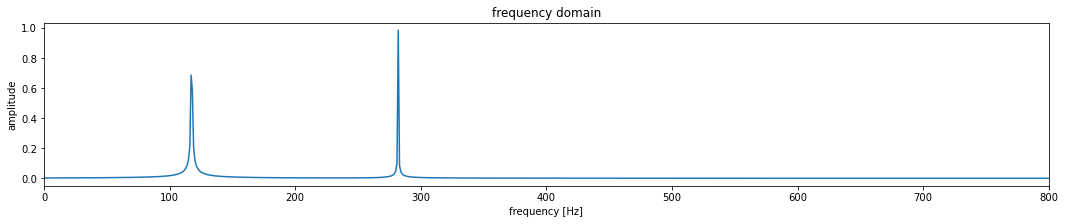

In [10]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('frequency domain')
ax.plot(frequencies, np.abs(S))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, 800);

The plot displays two peaks in spectral energy at 

In [11]:
peaks = argrelextrema(np.abs(S), np.greater)      # this function finds local maxima  
print(f' first peak detected at {frequencies[peaks[0][0]]:.3f} Hz.')
print(f'second peak detected at {frequencies[peaks[0][1]]:.3f} Hz.')

 first peak detected at 117.000 Hz.
second peak detected at 282.000 Hz.


Notice how the frequencies are close to the frequencies we computed above (`f1` and `f2`) but because `frequencies` is quantized and (in our case) increases in 1 Hz increments, the retrieved spectral peaks are restricted to be an integer number of Hz. This is why Brennan et al. call this the coarse range measurment. 

## 6. Convert frequency to range

Next we convert `frequencies` to depths using a combination of {eq}`eq:tau1` and {eq}`eq:f_d1`,

$
f_d = 2KR\frac{\sqrt\epsilon}{c},
$

Rearranging this expression for $R$ gives

In [12]:
range = frequencies * c /(2*K*np.sqrt(ep))

which allows us to produce the amplitude-range plot:

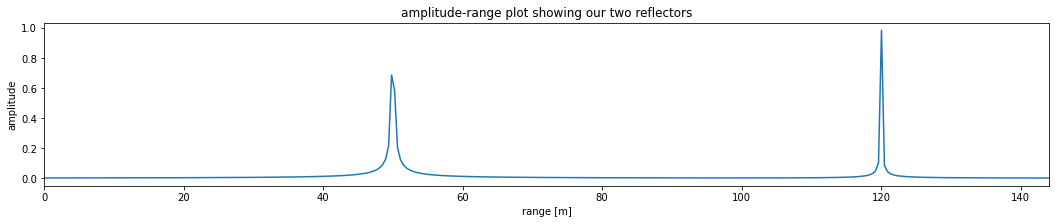

In [13]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('amplitude-range plot showing our two reflectors')
ax.plot(range, np.abs(S))
ax.set_xlabel('range [m]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, R2*1.2);

...and compute the range of the reflectors:

In [14]:
print(f' first reflector detected at {range[peaks[0][0]]:.3f} m.')
print(f'second reflector detected at {range[peaks[0][1]]:.3f} m.')

 first reflector detected at 49.804 m.
second reflector detected at 120.041 m.


The retrieved ranges to the two reflectors are close to the prescribed values:

In [15]:
print(R1) 
print(R2)

50.0
120.0


but, again, they are a coarse measurement due to the resolution of the frequency spectrum, which in turn derives from the bandwidth, $B$ and the rate of increase in frequencies $K$. 

## below this is scrap

In [16]:
phase = np.angle(S)
print(f' first reflector detected at {phase[peaks[0][0]]:.3f} rad.')
print(f'second reflector detected at {phase[peaks[0][1]]:.3f} rad.')

 first reflector detected at 1.446 rad.
second reflector detected at -0.303 rad.


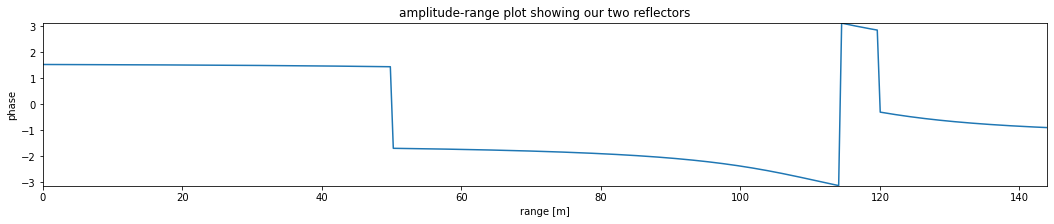

In [17]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('amplitude-range plot showing our two reflectors')
ax.plot(range, np.angle(S))
ax.set_xlabel('range [m]')
ax.set_ylabel('phase')
ax.set_xlim(0, R2*1.2);
ax.set_ylim(-np.pi, np.pi);

In [18]:
f_c = 300e6       # [Hz]
lam = c/np.sqrt(ep) / f_c
Rfine1 = lam * phase[peaks[0][0]]/(4*np.pi)
Rfine2 = lam * phase[peaks[0][1]]/(4*np.pi)
print(Rfine1)
print(Rfine2)

0.06530727388987519
-0.013693240278268263


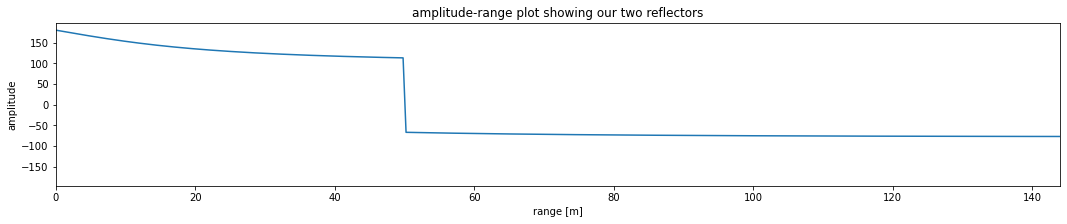

In [19]:

# this does not recreate the phase analysis here: https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/


#X2=X;%store the FFT results in another array
#%detect noise (very small numbers (eps)) and ignore them
#threshold = max(abs(X))/10000; %tolerance threshold
#X2(abs(X)<threshold) = 0; %maskout values that are below the threshold
#phase=atan2(imag(X2),real(X2))*180/pi; %phase information
#plot(f,phase); %phase vs frequencies
phi_shift = 30*np.pi/180
s = np.cos(2*np.pi*f1*t + phi_shift)

no_of_samples = len(s)
S = np.fft.fft(s)/no_of_samples         
indexes      = np.arange(no_of_samples) 
frequencies  = indexes * sampling_frequency/no_of_samples

range = frequencies * c /(2*K*np.sqrt(ep))

S2 = S
threshold =np.abs(S).max()/1000
S2[np.abs(S)<threshold] = 0
phase = np.arctan2(S2.imag,S2.real)*180/np.pi


fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('amplitude-range plot showing our two reflectors')
ax.plot(range, phase)
ax.set_xlabel('range [m]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, R2*1.2);